# Fine-tune des Mobilenet_V2
---

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

## Model einladen aus Keras
- Weights aus den Imagnet Dataset traniert
- Erwarteten Input 224,224, 3 

In [2]:
from keras.applications.mobilenet_v2 import MobileNetV2

# 1. Lade das vortrainierte MobileNetV2 Modell mit ImageNet-Gewichten
# include_top erstellt das Neurale Netz mit den verbunden Output Layer von 1000 Klasesen
# input shape: Das Mobilenetv2 erwarte ein Input von 224x 224, 3
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


### Binary Classification

### Weights und Bais des Hauptmodel werden eingeforen damit sie sich nicht verändern

Zum Basis modell werden 3 Neue sichten hinzugefügt 
- GlobalAveragePooling2D
- Dense Layer
- Dense Layer mit Sigmoid für die Binäre Klassifikation

In [3]:
# 2. Friere die Basis (MobileNetV2) ein damit nicht das ganze Model neu Traniert wird da diese zulange dauert
base_model.trainable = False

# 3. Erstelle das neue Modell, indem du zusätzliche Schichten hinzufügst
# zu den vorhanden Model werden nun drei weitere schichten hinzugefügt jedoch für eine Binäre Klassifikation da wir am
# Ende die Aktivierungsfunktion sigmoid mitgeben 


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Globales Pooling der Features
    layers.Dense(1024, activation='relu'),  # Neue Dense-Schicht
    layers.Dense(1, activation='sigmoid')   # Ausgabe-Schicht für binäre Klassifikation
])


In [4]:
# 4. Kompiliere das Modell (nur die hinzugefügten Schichten werden trainiert)
# loss binary_crossentrophy binäre Klassifiezierung Modell 
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', # binär
              metrics=['accuracy'])

In [5]:
# 5. Vorbereitung der Bilddaten (Beispiel: Lade Daten aus Verzeichnissen)
# Das Modell wird Robuster gemacht indem wir das Bild mehrfach Transformieren, drehen, zommen 
train_datagen = ImageDataGenerator(rescale=1.0/255.0,  # Normalisierung
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_dir = r'cats_and_dogs_small\train\100_pic'            # Dein Trainingsdaten-Verzeichnis
validation_dir = r'cats_and_dogs_small\validation/100_pic'  # Dein Validierungsdaten-Verzeichnis

#Achtung die Klassen werden aus dem Verzeichnis erstellt wir haben in dem Ornder "100_pic" zwei Weitere Ordner namens Cat und Dogs 
# woraus sich die Klassen herausstellen haben wir weitere Ordner wie Pferd und Wolf haben wir 4 Klassen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 202 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [7]:
import json
import os

# Überprüfen, ob das Modell bereits existiert umso Ressourcen zupassen falls ein Modell bereits hinterlegt wurde
path_to_model = r"model/fine_tuned_model.keras"

if os.path.isfile(path_to_model):
    history = load_model(path_to_model)
    print("exist")

else:       
    # Falls kein Modell da ist wird das Modell trainiert und nur das Beste modell gespeichert.
    # Trainiere das Modell
    history = model.fit(
        train_generator,
        epochs=8,
        validation_data=validation_generator,
        callbacks=[  # Optionale Callbacks (z.B. für das Speichern des besten Modells)
            keras.callbacks.ModelCheckpoint('model/fine_tuned_model.keras', save_best_only=True, monitor='val_loss')
        ]
    )
    
    # Die Parameter in History werden zwischen gespeichert in einer JSON da sonst später die History nicht ausgeben werden kann.

    history_dict = history.history  # Das History-Objekt enthält alle Metriken
    with open('train_history.json', 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)

# TODO: Ordner erstellen wo der JSON gespeichert wird.

c:\Users\riandrea\Desktop\Github\SceneDetect\project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6841 - loss: 1.5995

c:\Users\riandrea\Desktop\Github\SceneDetect\project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.6846 - loss: 1.5525 - val_accuracy: 0.9554 - val_loss: 0.1218
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.8839 - loss: 0.2468 - val_accuracy: 0.9406 - val_loss: 0.1098
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - accuracy: 0.9506 - loss: 0.1169 - val_accuracy: 0.9604 - val_loss: 0.1200
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 674ms/step - accuracy: 0.9633 - loss: 0.0902 - val_accuracy: 0.9802 - val_loss: 0.0578
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 618ms/step - accuracy: 0.9619 - loss: 0.1024 - val_accuracy: 0.9752 - val_loss: 0.0768
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step - accuracy: 0.9779 - loss: 0.0661 - val_accuracy: 0.9802 - val_loss: 0.0494
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step - accuracy: 0.9911 - loss: 0.0235 - val_accuracy: 0.9851 - val_loss: 0.0271
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - accuracy: 0.9695 - loss: 0.0750 - val_accuracy: 0.9752 - val_loss: 0.0572


In [8]:
# Evaluierung des Modells auf den Validierungsdaten
eval_results = model.evaluate(validation_generator)
print(f"Loss: {eval_results[0]}")
print(f"Accuracy: {eval_results[1]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9780 - loss: 0.0440
Loss: 0.05717777460813522
Accuracy: 0.9752475023269653


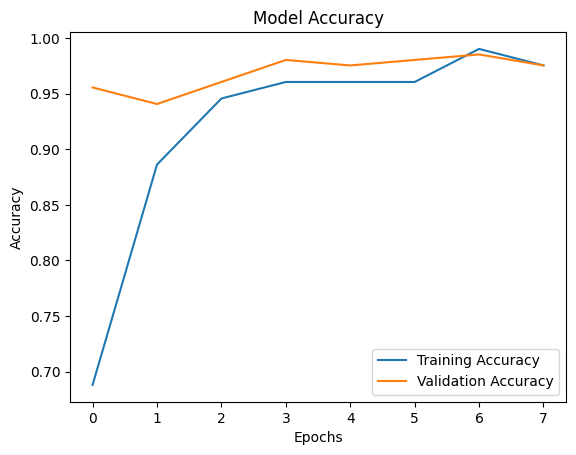

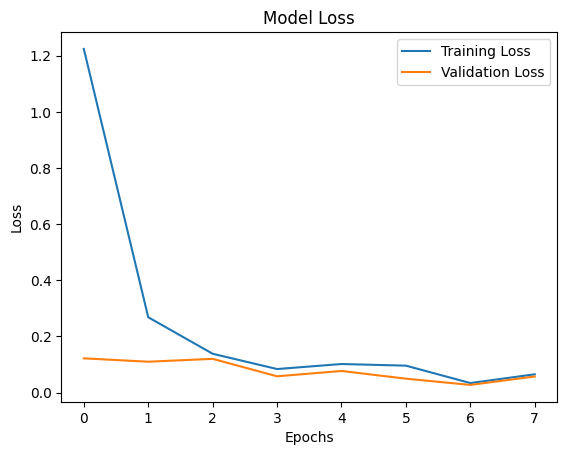

In [9]:
import json
import matplotlib.pyplot as plt

# Laden der JSON-Datei mit den Trainingsdaten
with open('train_history.json', 'r') as json_file:
    history_dict = json.load(json_file)

# Beispiel für das Plotten der Trainings- und Validierungsgenauigkeit
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Beispiel für das Plotten des Trainings- und Validierungsverlusts
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Lade das Bild, das du testen möchtest
img_path = r'cats_and_dogs_small\train\cats\155.jpg'  # Pfad zum Bild, das du testen möchtest

# Lade das Bild und skaliere es auf die Eingabegröße des Modells
img = image.load_img(img_path, target_size=(224, 224))

# 2. Konvertiere das Bild in ein Array und normalisiere es
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Füge eine Batch-Dimension hinzu
img_array /= 255.0  # Normalisiere das Bild (falls beim Training auch normalisiert wurde)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Das Bild zeigt die Katzen Klasse.


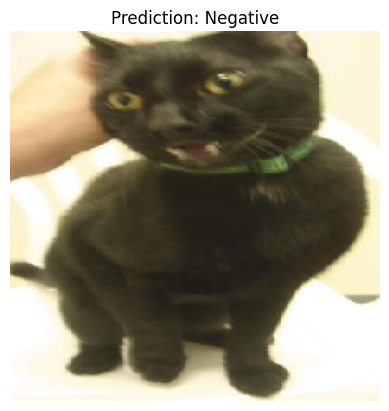

[[0.00596699]]


In [20]:

# 3. Vorhersage des Modells
predictions = model.predict(img_array)

# 4. Interpretiere die Vorhersage
# Hier nehmen wir an, dass es sich um ein binäres Klassifikationsproblem handelt
# (z.B. Hund vs. Katze)

# Bei binärer Klassifikation gibt das Modell eine Wahrscheinlichkeit zurück
# Wenn die Wahrscheinlichkeit größer als 0.5 ist, dann gehört das Bild zur positiven Klasse
if predictions[0] > 0.5:
    print("Das Bild zeigt die Hund Klasse.")
else:
    print("Das Bild zeigt die Katzen Klasse.")

# 5. (Optional) Visualisiere das Bild
plt.imshow(img)
plt.title(f'Prediction: {"Positive" if predictions[0] > 0.5 else "Negative"}')
plt.axis('off')  # Verstecke die Achsen
#plt.text(x=0,y=0,s=str(predictions))
plt.show()
print(predictions)

----

## Mehrere Klassifikationen erstellen:

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
import imageio.v2 as imageio  # Verwende imageio.v2, um das alte Verhalten beizubehalten
from PIL import Image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions
# 1. Lade das vortrainierte MobileNetV2 Modell mit ImageNet-Gewichten
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))


In [ ]:
image = r"C:\Users\riandrea\Desktop\Github\SceneDetect\cats_and_dogs_small\validation\dogs\1051.jpg"

In [ ]:
# Bild laden
img = imageio.imread(image)
# Bild auf die gewünschte Größe (224, 224) skalieren
img_resized = Image.fromarray(img).resize((224, 224))
# Bild in das numpy Array einfügen
data = np.empty((1, 224, 224, 3))
data[0] = np.array(img_resized)
data = preprocess_input(data)
predictions = model.predict(data)
print('Shape: {}'.format(predictions.shape))
output_neuron = np.argmax(predictions[0])
print('Most active neuron: {} ({:.2f}%)'.format(
    output_neuron,
    100 * predictions[0][output_neuron]
))
for name, desc, score in decode_predictions(predictions)[0]:
    print('- {} ({:.2f}%%)'.format(desc, 100 * score))

In [ ]:
# 2. Friere die Basis (MobileNetV2) ein
base_model.trainable = False

# 3. Erstelle das neue Modell, indem du zusätzliche Schichten hinzufügst
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Globales Pooling der Features
    layers.Dense(1024, activation='relu'),  # Neue Dense-Schicht
    layers.Dense(1, activation='cate')   # Ausgabe-Schicht für binäre Klassifikation
])


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

# Modell laden
model_path = r"model\convnet_from_scratch.keras"
model = tf.keras.models.load_model(model_path)

# Modell kompilieren
model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

# ImageDataGenerator für das Training und die Validierung erstellen
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normiere die Pixelwerte
    rotation_range=40,  # Beispiel: Rotation für mehr Variabilität
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Lade die Trainings- und Validierungsdaten aus den Verzeichnissen
train_dir = r"cats_and_dogs_small\train"
validation_dir = r"cats_and_dogs_small\validation"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),  # Beispiel für eine Zielgröße
    batch_size=32,
    class_mode='binary'  # Da du einen binären Klassifikator verwendest (z. B. Hund/Katze)
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# Modell trainieren
callbacks = [
    ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)


In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")